## Imports

In [ ]:
# Imports
from __future__ import division
from datetime import datetime, date
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from typing import List
from scipy.stats import spearmanr

import warnings
# Suppress FutureWarnings, currently being rarised about XGBoost's use of pandas Int64Index
warnings.simplefilter(action='ignore', category=FutureWarning)

import xgboost as xgb
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import itertools

In [ ]:
# Define relabel_clusters(), cluster_data(), plot_histogram(), and is_return_without_purchase() 

def cluster_data(data: pd.DataFrame, kmeans: KMeans, cols_to_cluster: List[str]) -> None:
    """
    Fit a Kmeans model to a dataframe for a specified cluster column; assign cluster values to the data
    
    Args:
        data: the data to process
        kmeans: an object of the class sklearn.cluster._kmeans.KMeans
        cols_to_cluster: the columns upon which to cluster, e.g. ['Recency']
    """
    kmeans.fit(data[cols_to_cluster])
    new_col_name = '_'.join(cols_to_cluster)
    data[f'{new_col_name}_Cluster_(k={kmeans.n_clusters})'] = kmeans.predict(data[cols_to_cluster])

    return data

def relabel_clusters(data: pd.DataFrame, cluster_col: str, cluster_col_orig: str, ascending: bool) -> pd.DataFrame:
    """
    Re-label clusters so that a higher cluster label indicates a better R, F or M score
    
    Args:
        data: the data to process
        cluster_col: the column containing cluster labels, e.g. 'Recency_Cluster'
        cluster_col_orig: the column which was used to create the clusters, e.g. 'Recency'
        ascending: whether a higher mean cluster_col_orig value is better (ascending=True) or worse
        (ascending=False). E.g. if cluster_col_orig='MonetaryValue', ascending=True
        
    """
    # Group by cluster labels and get the mean of cluster_col_orig per cluster label
    data_tmp = data.groupby(cluster_col)[cluster_col_orig].mean().reset_index()
    # Sort by cluster_col_orig values and drop the index
    data_tmp = data_tmp.sort_values(by=cluster_col_orig, ascending=ascending).reset_index(drop=True)
    # Assign a new rank column using the index of the sorted data
    data_tmp['Rank'] = data_tmp.index
    # Merge the two data frames on the cluster labels, drop the original cluster label column, replace it with rank
    data_new = (pd.merge(data, data_tmp[[cluster_col, 'Rank']], on=cluster_col)
                .drop([cluster_col], axis=1)
                .rename(columns={"Rank": cluster_col}))
                
    return data_new

def plot_histogram(data: pd.Series, x_title: str, y_title: str, title: str) -> None:
    """
    Plot a histogram given a pandas datta series
    
    Args:
        data: the pandas series, e.g. df[some_column]
        x_title, y_title: titles for the x and y axes, respectively
        title: title of the plott itself
    """
    fig = go.Figure()
    fig.add_trace(
        go.Histogram(x=data)
    )
        
    fig.update_layout(xaxis_title=x_title,
                      yaxis_title=y_title,
                      title=title,
                      hovermode='x unified')
    fig.show()
    
def is_return_without_purchase(df: pd.DataFrame, df_row: pd.Series) -> bool:
    """
    Determine whether a transaction is a return without a corresponding purchase    
    Args:
        df: a dataframe of transaction data, including at least the columns 'CustomerID', Quantity' and 'StockCode'
        df_row: a row of a dataframe of transaction data, also including these columns
    Returns:
        True if a transaction is a return without a corresponding purchase, else False
    """
    if df_row['Quantity'] > 0:
        return False # Can't be a return without purchase as it's not a return
    else:
        customer_id = df_row['CustomerID']
        quantity = df_row['Quantity']
        stock_code = df_row['StockCode']

        matching_purchases = df[
            (df['CustomerID'] == customer_id) & (df['StockCode'] == stock_code) & (df['Quantity'] == abs(quantity))
        ]

        if len(matching_purchases) > 0:
            return False # Can't be a return without purchase as corresponding purchases were found
        else:
            return True

In [ ]:
# Set the random state for the whole notebook
rand_state=1

## Schritt 1: Die Daten Lesen; Den Zeitrahmen festlegen

In [ ]:
# Read data; convert InvoiceDate to datetime
try:
    df_data = pd.read_csv('OnlineRetail_Preprocessed.csv', parse_dates=['InvoiceDate'])
except FileNotFoundError:
    print('Please check that the notebook "Customer_Segmentation.ipynb" executed successfully')

Jetzt müssen wir unsere Daten in zwei Zeiträume aufteilen. Der frühere Zeitraum wird für die Berechnung unserer R-, F- und M-Merkmale verwendet, der letztere für die Vorhersage des Lifetime Value*.

Die Wahl der Zeiträume hängt von der Länge der verfügbaren Eingabedaten sowie von der Branche und dem Einzelhandelssegment ab, in dem Sie tätig sind.

Da unsere Daten etwa 12 Monate lang sind, werden wir sie in zwei Abschnitte von jeweils etwa sechs Monaten aufteilen, wobei der 6. Juni als Stichtag gilt. Wir werden einen split_date-Parameter erstellen, so dass Sie das Datum leicht ändern und selbst experimentieren können.

In [ ]:
# Examine the time span of the data
data_span_days = (df_data.InvoiceDate.max() - df_data.InvoiceDate.min()).days
print(f'Data span in days: {data_span_days}.')
print(f'Min/max dates (YYYY-MM-DD): {df_data.InvoiceDate.min()}, {df_data.InvoiceDate.max()}')

In [ ]:
# Create dataframes for a pre-threshold period and post-threshold period (date format = YYYY-MM-DD)
# The first period data is from the min date to (but not including) split_date
# The second period data is from split_date to the max date

split_date = pd.to_datetime(date(2011,6,1))
df_pre = df_data[df_data.InvoiceDate < split_date].reset_index(drop=True)
df_post = df_data[df_data.InvoiceDate >= split_date].reset_index(drop=True)
print(f"Num records in pre-period: {len(df_pre)}; and in post-period: {len(df_post)}")

## Schritt 2: Die Werte für Recency, Frequency und Revenue (MonetaryValue) berechnen

In [ ]:
# create df_customer for assigning clustering (will be a dataframe with just one column, CustomerID)
df_customer = pd.DataFrame(df_pre.CustomerID.unique(), columns=['CustomerID'])

In [ ]:
# Recency in days
df_max_purchase = df_pre.groupby('CustomerID').InvoiceDate.max().reset_index()
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
max_of_max_dates = df_max_purchase['MaxPurchaseDate'].max()
df_max_purchase['Recency'] = (max_of_max_dates - df_max_purchase['MaxPurchaseDate']).dt.days
df_customer = pd.merge(df_customer, df_max_purchase, on='CustomerID')

In [ ]:
# Frequency (& Bonus column: Lifespan)

# Add each customer's minimum purchase date
df_min_purchase = df_pre.groupby('CustomerID').InvoiceDate.min().reset_index()
df_min_purchase.columns = ['CustomerID','MinPurchaseDate']

# Merge this dataframe to our new customer dataframe
df_customer = pd.merge(df_customer, df_min_purchase, on='CustomerID')

# Calculate each customer's lifespan
df_customer['Lifespan'] = (df_customer.MaxPurchaseDate - df_customer.MinPurchaseDate).dt.days
df_customer.drop(columns=['MinPurchaseDate', 'MaxPurchaseDate'], inplace=True)

# Get the number of purchases for each customer and create a dataframe with it; combine with df_customer
df_pre['InvoiceDate_Date'] = df_pre['InvoiceDate'].dt.normalize()
df_frequency = df_pre.groupby('CustomerID').InvoiceDate_Date.nunique().reset_index()
df_pre.drop(columns=['InvoiceDate_Date'], inplace=True)
df_frequency.columns = ['CustomerID','Frequency']

df_customer = pd.merge(df_customer, df_frequency, on='CustomerID')

In [ ]:
# MonetaryValue
df_pre['MonetaryValue'] = df_pre['UnitPrice'] * df_pre['Quantity']
df_monetary_value = df_pre.groupby('CustomerID').MonetaryValue.sum().reset_index()
df_customer = pd.merge(df_customer, df_monetary_value, on='CustomerID')

## Visualise the prepared R, F & M scores

Obwohl wir diese Schritte bereits durchgeführt haben, ist es wichtig, dass wir die Daten erneut überprüfen. Das liegt daran, dass sich die Datenlage geändert hat: Wir betrachten jetzt nur noch die ersten paar Monate.

In [ ]:
# Visualise the distributions of R, F & M values per shopper
rfm_cols = ['Recency', 'Frequency', 'MonetaryValue']
titles = ['Recency Score Per Shopper',
          'Purchase Frequency Values per Shopper',
          'Monetary Value Values per Shopper']

for col, title in zip(rfm_cols, titles):
    plot_histogram(data=df_customer[col], x_title=col, y_title='Count', title=title)

In [ ]:
# Examine the final R, F & M scores
print("Summary statistics:")
display(df_customer.describe().round(2))

In [ ]:
# Check how many negative MonetaryValue post rows we have
print(f"Num. rows where MonetaryValue < 0: {len(df_customer[df_customer['MonetaryValue'] < 0])}")
print(f"Num. rows where MonetaryValue == 0: {len(df_customer[df_customer['MonetaryValue'] == 0])}")

In [ ]:
# Remove negative MonetaryValue rows
df_customer = df_customer.copy().query('MonetaryValue >= 0')

In [ ]:
# Handle 0-valued MonetaryValue and Recency rows
df_customer['Recency'] += 1
df_customer['MonetaryValue'] += 1

In [ ]:
# Apply the log transformation
for col in rfm_cols:

    df_customer[f'{col}_log'] = np.log10(df_customer[[col]])
    # A note on log10, for the unsure:
    # An explanation of logarithms is beyond the scope of this course, but resources are available online
    # Example: https://www.mathsisfun.com/algebra/logarithms.html
    
    #  Visualise the transformed scores
    plot_histogram(data=df_customer[f'{col}_log'],
                   x_title=f'{col} (Log-Transformed)',
                   y_title='Count',
                   title=col)

## Schritt 3: Kunden anhand ihrer R-, F- und M-Bewertungen clustern

### Die Anzahl von Clustern bestimmen

In [ ]:
# Try different k values for the R, F & M columns and plot the results
rfm_log_cols = [f'{col}_log' for col in rfm_cols]
for col in rfm_log_cols:
    ssd={}
    
    tmp = df_customer[[col]].reset_index()
    for k_tmp in range(1, 10):
        kmeans = KMeans(n_clusters=k_tmp, max_iter=1000, random_state=rand_state).fit(tmp)
        ssd[k_tmp] = kmeans.inertia_
        
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=list(ssd.keys()),
                   y=list(ssd.values()),
                   mode='lines'))

    fig.update_layout(xaxis_title='Number of Clusters',
                      yaxis_title='SSD',
                      title=f'SSD per Number of Clusters for {col}',
                      hovermode='x unified')
    fig.show()
    print(ssd)

In [ ]:
# Build our clusters for the R, F & M columns and add them to the dataframe
k_range = [2,3,4]
for k_tmp in k_range:
    kmeans = KMeans(n_clusters=k_tmp, max_iter=1000, random_state=rand_state)
    for col, asc in zip(rfm_log_cols, [False, True, True]):
        df_customer = cluster_data(data=df_customer, kmeans=kmeans, cols_to_cluster=[col])
        df_customer = relabel_clusters(data=df_customer,
                                       cluster_col=f'{col}_Cluster_(k={k_tmp})',
                                       cluster_col_orig=col,
                                       ascending=asc)

In [ ]:
# Visualise the clusters in order to help choose the best value of k
k_range = [2,3,4]
for col in rfm_cols:
    for k_tmp in k_range:
        fig = go.Figure()    
        fig.add_trace(
            go.Scatter(
                x=df_customer[col], y=np.random.randint(low=0, high=100, size=len(df_customer)), mode='markers',
                marker_color=df_customer[f'{col}_log_Cluster_(k={k_tmp})'], marker_colorscale='plotly3',
                hovertemplate=f'{col}'+': %{x}'
                              '<extra></extra>'
            )
        )
        
        fig.update_layout(
            xaxis_title=col, title=f'{col} Values in {k_tmp} Clusters',
            yaxis = go.layout.YAxis(title='Random Scatter', showticklabels=False)
        )
        fig.show()

## Scritt 3 Bonus: Die R, F, M Spalten auf einmal Clustern

In [ ]:
# Bring all three columns into the same scale
scaler = StandardScaler(with_mean=True, with_std=True)

for col in rfm_log_cols:
    scaler.fit(df_customer[[col]])
    df_customer[f'{col}_scaled'] = scaler.transform(df_customer[[col]])
    
rfm_cols_scaled = [f'{col}_scaled' for col in rfm_log_cols]
df_customer[rfm_cols_scaled].describe().round(2)

In [ ]:
# Build a cluster over all three R,F,M columns at once
k=2
kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=rand_state)

df_customer = cluster_data(data=df_customer,
                           kmeans=kmeans,
                           cols_to_cluster=rfm_cols_scaled)
df_customer.rename(columns={
    f'Recency_log_scaled_Frequency_log_scaled_MonetaryValue_log_scaled_Cluster_(k={k})':f'Multi_Cluster_(k={k})'
}, inplace=True
)

df_customer = relabel_clusters(data=df_customer,
                               cluster_col=f'Multi_Cluster_(k={k})',
                               cluster_col_orig='MonetaryValue',
                               ascending=True)

__Challenge: Visualisierung von Feature Kombinationen mit Plotly und Itertools__

Zeichnen Sie für alle Kombinationen von zwei Features, die mit den drei Features in unserer Multicluster-Spalte möglich sind, ein Streudiagramm mit einem Feature pro x- und y-Achse. Jedes FEature sollte die Chance haben, in der gleichen Kombination auf der x- und der x-Achse zu liegen. Das heißt, in einem Diagramm:

X = Merkmal_A, Y = Merkmal_B

und in einem anderen Diagramm:

X = Merkmal_B, Y = Merkmal_A

und dies sollte (in beliebiger Reihenfolge) für alle möglichen Kombinationen von zwei Featuesr wiederholt werden.

Sie können die anderen Streudiagramme, die wir im Laufe dieses Kurses erstellt haben, als Leitfaden verwenden, um alle go.Scatter()-Parameter zu füllen, nämlich x, y, mode und marker_color. Und vergessen Sie nicht, Achsentitel und einen Plot-Titel mit fig.update_layout() hinzuzufügen.

Und hier noch ein letzter Tipp: Sie können permutations() aus der itertools-Library verwenden, um Merkmalskombinationen zu erzeugen. Sie können die Liste der RFM-Spalten übergeben und r=2 angeben, d. h. Sie möchten, dass Kombinationen der Länge 2 erzeugt werden, etwa so:

list(itertools.permutations(rfm_cols_scaled, r=2))


Das Endergebnis sollte in etwa so aussehen:

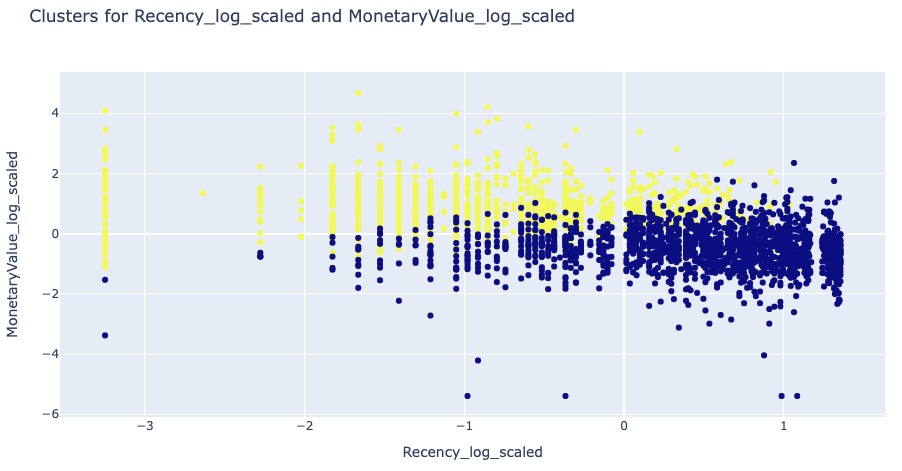

In [ ]:
# Generate variable combinations to visualise
var_combos = list(itertools.permutations(rfm_cols_scaled, r=2))
var_combos

In [ ]:
# Visualise clusters per variable permutation
for var_combo in var_combos:
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=df_customer[var_combo[0]],
                   y=df_customer[var_combo[1]],
                   mode='markers',
                   marker_color=df_customer[f'Multi_Cluster_(k={k})'])
    )
    fig.update_layout(xaxis_title=var_combo[0],
                      yaxis_title=var_combo[1],
                      title=f'Clusters for {var_combo[0]} and {var_combo[1]}',
                      hovermode='x unified')
    fig.show()

## Schritt 4: Berechnung der Gesamtpunktzahl pro Kunde

In [ ]:
# Calculate overall scores
k = 2
df_customer['OverallScore'] = (df_customer[f'Recency_log_Cluster_(k={k})']
                           + df_customer[f'Frequency_log_Cluster_(k={k})']
                           + df_customer[f'MonetaryValue_log_Cluster_(k={k})'])
                           
df_customer.groupby('OverallScore')[['Recency','Frequency','MonetaryValue']].mean()

In [ ]:
# Visualise the number of customers per score (helps in assigning Tiers)
pd.DataFrame(df_customer.value_counts('OverallScore')).reset_index().sort_values(by='OverallScore')

In [ ]:
# Visualise the distributions of OverallScore (helps in assigning Tiers)
for col in rfm_cols:
    fig = go.Figure()
    for score in sorted(df_customer['OverallScore'].unique()):
        fig.add_trace(go.Box(y=df_customer.loc[df_customer['OverallScore'] == score][col], name=f'Score={score}'))
    fig.update_layout(title=f'Score distributions for {col}')
    fig.show()

In [ ]:
# Assign customers to tiers; show how many customers we have per tier
df_customer['Tier'] = 'Low-Value'
df_customer.loc[df_customer['OverallScore'] == 1,'Tier'] = 'Mid-Value' 
df_customer.loc[df_customer['OverallScore'] >= 2,'Tier'] = 'High-Value'

## Schritt 5: Der LTV-Werte für die nächsten N Monate berechnen

Nun wollen wir den LTV der Kunden für die nächsten Monate (also, für die Kunden, die nach unserem ursprünglichen Cutoff-Date gekauft haben) berechnen. In diesem Fall ist der LTV einfach der MonetaryValue; in anderen Beispielen aus der Praxis könnten wir Kosteninformationen berücksichtigen, da einige Kunden vielleicht dazu neigen, Artikel zu kaufen, die dem Unternehmen mehr Kosten verursachen als andere Artikel. Beispiele für diese Kosten:
- die Kosten der verkauften Waren sein (wie viel es das Unternehmen kostet, den zu verkaufenden Artikel zu erwerben)
- Lagerkosten
- Werbekosten
- Versandkosten und so weiter.

In [ ]:
# Calculate MonetaryValue and create a new dataframe for it
df_post['MonetaryValue_post'] = df_post['UnitPrice'] * df_post['Quantity']
df_customer_post = (df_post
                    .groupby('CustomerID')['MonetaryValue_post']
                    .sum()
                    .reset_index())
df_customer_post.columns = ['CustomerID','MonetaryValue_post']

In [ ]:
# Visualise MonetaryValue_post values
title = f'Monetary Value ({datetime.date(df_post.InvoiceDate.min())} to {datetime.date(df_post.InvoiceDate.max())})'

plot_histogram(data=df_customer_post['MonetaryValue_post'], x_title='', y_title='', title=title)

In [ ]:
# Handle the negative and 0-valued MonetaryValue_post rows
print(f"Num. rows where MonetaryValue_post < 0: {len(df_customer_post[df_customer_post['MonetaryValue_post'] < 0])}")
print(f"Num. rows where MonetaryValue_post == 0: {len(df_customer_post[df_customer_post['MonetaryValue_post'] == 0])}")
df_customer_post = df_customer_post[df_customer_post['MonetaryValue_post'] >= 0]
df_customer_post['MonetaryValue_post'] += 1

In [ ]:
# Log transform MonetaryValue_post
df_customer_post['MonetaryValue_post_log'] = np.log10(df_customer_post[['MonetaryValue_post']])

In [ ]:
# Visualise transformed MonetaryValue_post values
title = f'MonetaryValue (log) ({datetime.date(df_post.InvoiceDate.min())} to {datetime.date(df_post.InvoiceDate.max())})'

plot_histogram(data=df_customer_post['MonetaryValue_post_log'], x_title='', y_title='', title=title)

In [ ]:
# Combine the original df_customer with the df_customer_post data

# Join df_customer_post onto df_customer, keeping the keys of df_customer
# This will produce rows with NaN for MonetaryValue_post(_log) 
# (i.e. customers who were in df_customer_post but not df_customer)
# We will fill these with zeros
df_merged = pd.merge(df_customer, df_customer_post, on='CustomerID', how='left').fillna(0)
df_merged.sample(5)

Das Ziel unseres maschinellen Lernmodells wird es sein, vorherzusagen, in welche Stufe jeder Kunde fällt. Auch hier werden wir K-Means-Clustering verwenden, um LTV-Gruppen zu bestimmen und daraus Segmente zu ermitteln. 

## Schritt 6: LTV-Clusters als unsere Trainingsetiketten erstellen

Wenn wir einen tatsächlichen Wert für den LTV vorhersagen wollten, wäre es ein Problem der linearen Regression. Aber das ist es nicht; wir wollen Segmente vorhersagen, da diese nützlicher sind. Daher werden wir die Segmente als Trainingsetiketten verwenden.

In [ ]:
# Cluster our MonetaryValue_post_log values
k = 3 # We have chosen 3 because we have 3 customer tiers
kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=rand_state)
df_merged = cluster_data(data=df_merged,
                         kmeans=kmeans,
                         cols_to_cluster=['MonetaryValue_post_log'])

df_merged.rename(columns={f'MonetaryValue_post_log_Cluster_(k={k})':'LTV_Cluster'}, inplace=True)

df_merged = relabel_clusters(data=df_merged,
                            cluster_col='LTV_Cluster',
                            cluster_col_orig='MonetaryValue_post',
                            ascending=True)

In [ ]:
# Visualise the number of customers per LTV cluster
pd.DataFrame(df_merged.value_counts('LTV_Cluster')).reset_index().sort_values(by='LTV_Cluster')

## Schritt 7: Der Daten für das maschinelle Lernmodell vorbereiten

In [ ]:
# Encode the 'Tier' column using sklearn's OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
df_tier = df_merged[['Tier']]
encoder.fit(df_tier)
df_tier = encoder.transform(df_tier)
df_tier = pd.DataFrame(df_tier, columns=encoder.get_feature_names_out())
df_tier.sample(5)

In [ ]:
# Combine the new one-hot encoded columns with the rest of the data
df_merged = pd.concat([df_merged, df_tier], axis=1)

Es ist wichtig, die Beziehung zwischen den Merkmalen in unserem Datensatz und unserer Zielvariablen, LTV_Cluster, zu verstehen. Wir werden daher die Korrelationen betrachten.

Wir werden die Spearman-Korrelationsmethode verwenden, da sie für ordinale Daten wie LTV-Cluster konzipiert ist. Wir werden keine Korrelationen für "CustomerID", "MonetaryValue_post", "MonetaryValue_post_log" darstellen. Die ersten beiden sind irrelevant, die beiden letzteren wurden zur Erstellung des LTV-Clusters verwendet, so dass sie natürlich korreliert sind. 

In [ ]:
# Calculate correlations between features and target
corr_cols = list(set(df_merged.columns) - {'CustomerID', 'MonetaryValue_post', 'MonetaryValue_post_log'})
corr_method='spearman'
corr = df_merged[corr_cols].corr(method=corr_method)
pd.DataFrame(corr['LTV_Cluster'].sort_values(ascending=False))

In [ ]:
# Plot the feature correlations
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        z=corr,
        x=corr.columns,
        y=corr.columns
    )
)

fig.update_layout(title=f'{corr_method.title()} Feature Correlations',
                  height=700,
                  yaxis_nticks=len(corr))

## Schritt 8: Erstellung und Training des maschinellen Lernmodells

__Challenge: Festlegung der Grundgenauigkeit des Modells__

Bevor wir fortfahren, wollen wir sehen, wie hoch die Mindestgenauigkeit (minimum accuracy) sein wird. Dies ist die Größe des größten Clusters in unserem Datensatz, denn wenn wir davon ausgehen, dass jeder Eintrag in diesem Cluster ist, würde die Genauigkeit der proportionalen Größe dieses Clusters entsprechen. Dies müssen wir bei der Bewertung unseres Modells berücksichtigen.

Für diese Aufgabe möchte ich, dass Sie die Basisgenauigkeit in Prozent für unser Modell herausfinden. Das bedeutet, dass Sie den prozentualen Anteil jedes Clusters an unseren Daten ermitteln sollen. Der resultierende Datenrahmen sollte die Spalten LTV_Cluster, Count, Pct_Size (d.h. den Prozentsatz des gesamten Datenrahmens, der in jeden Cluster fällt) enthalten. Es bleibt Ihnen überlassen, ob Sie Pct_Size als Dezimalzahl, als Prozentsatz oder als formatierte Zeichenkette darstellen, z. B. 0.10 == 10 == '10%'.

Es gibt verschiedene Möglichkeiten, wie Sie dieses Problem lösen können. Hier sind einige Tipps für drei verschiedene mögliche Lösungen, die mir vorschweben. Sie müssen natürlich nicht alle (oder irgendeinen!) dieser Tipps anwenden, wichtig ist nur, dass wir am Ende das gleiche Ergebnis erhalten:

- Tipps für eine mögliche Lösung A:
    - len(df) liefert die Länge eines Datenrahmens, auch einer temporären Ansicht eines Datenrahmens
    - df['spaltenname'].unique() liefert die eindeutigen Werte in einer Spalte, z. B. der 'Cluster' spalte
    - eine for-Schleife kann nützlich sein, um eine Schleife über eindeutige Werte zu ziehen
    - query oder loc können verwendet werden, um eine temporäre Ansicht eines Datenrahmens auszuwählen, bei der eine bestimmte Spalte einem bestimmten Wert entspricht


- Tipps für eine mögliche Lösung B:
    - value_counts() liefert die Anzahl der Werte einer bestimmten Spalte
    - Sie können eine neue Spalte erstellen, indem Sie eine wiederholte mathematische Funktion über alle Zeilen ausführen, z. B. df['my_col_times_two'] = df['my_col'] * 2
    - Sie können auch eine neue Spalte durch 'assign' mit einer Lambda-Funktion erstellen


- Tipps für eine mögliche Lösung C:
    - value_counts(normalize=True) gibt die Anzahl der Werte einer bestimmten Spalte als Prozentsatz an
    - Mit pd.concat([df_a, df_b], axis=1, keys=['Count', 'Pct_Size']) können Sie zwei Datenrahmen verbinden, die die Spalten "Count" und "Pct_Size" enthalten

In [ ]:
# Challenge Solution (I've chosen solution B): Establish the Baseline Model Accuracy

(pd.DataFrame(df_merged.LTV_Cluster.value_counts())
 # Produces a df with the count of each cluster label, e.g:
 #     LTV_Cluster
 # 1   1057
 # 2   562
 # ... ...
 
 .reset_index()
 # Produces a df whose columns need renaming
 #      index LTV_Cluster
 # 0    1     1057
 # 1    2     562
 # ... ...
 
 .rename(columns={'index': 'LTV_Cluster', 'LTV_Cluster' : 'Count'})
 # The df still needs a percentage for each cluster size
 
 .assign(Pct_Size=lambda x: (x['Count']/len(df_merged)*100)))
# assign takes a new column name (Pct_Size) and an expression.
# Here we divide each Count value by lenth of the data and then * 100

In [ ]:
# Split data into a training and test set
test_size = 0.20
X_train_split, X_test_split, y_train, y_test \
= train_test_split(df_merged,
                   df_merged['LTV_Cluster'],
                   test_size=test_size,
                   random_state=rand_state)
print(f"Train set length: {len(X_train_split)};  test set length: {len(X_test_split)}")

In [ ]:
# X_train_split and X_test_split contain all features; we will use this for examining the model errors later
# But we need to drop the following columns for the actual train and test data

# Our train and test set, used for model evaluation
X_train = X_train_split.drop(columns=[
    'LTV_Cluster', 'MonetaryValue_post', 'MonetaryValue_post_log', 'Tier', 'CustomerID'
])
X_test = X_test_split.drop(columns=[
    'LTV_Cluster', 'MonetaryValue_post', 'MonetaryValue_post_log', 'Tier', 'CustomerID'
])

# Our input data, used for GridSearch CrossValidation
X = df_merged.drop(columns=[
    'LTV_Cluster', 'MonetaryValue_post', 'MonetaryValue_post_log', 'Tier', 'CustomerID'
])
y = df_merged['LTV_Cluster']

In [ ]:
# Create a model and hyperparameter grid

rf_model = RandomForestClassifier(random_state=rand_state)

# See all hyperparameter options at:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

param_grid = {
     # Number of trees in the forest. Default = 100
    'n_estimators': [10, 100, 500],
     # Num. features to consider when looking for the best split. Default=auto (which takes sqrt(n_features))
    'max_features': ['auto', 10, None],
     # Max tree depth. Default=None
    'max_depth' : [5, 10, 100, None],
    # If bootstrap is True (it is by default), the number of samples to draw from X to train each tree
    # If given as a float, draws max_samples * len(X), i.e. 1.0 would draw all samples
    'max_samples': [0.8, 1.0]
}

In [ ]:
# Alternative: start with a simple param_grid and set verbose=2, to get a feeling for the fit speed on your PC
# param_grid = {
#      # Number of trees in the forest. Default = 100
#     'n_estimators': [500],
#      # Num. features to consider when looking for the best split. Default=auto (which takes sqrt(n_features))
#     'max_features': [None],
#      # Max tree depth. Default=None
#     'max_depth' : [None],
#     # If bootstrap is True (it is by default), the number of samples to draw from X to train each tree
#     # If given as a float, draws max_samples * len(X), i.e. 1.0 would draw all samples
#     'max_samples': [1.0]
# }

In [ ]:
# Fit model using GridSearch hyperparameter tuning with Cross-Validation
cv = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(cv=cv, estimator=rf_model, param_grid=param_grid, verbose=1)
grid_search.fit(X, y)

## Schritt 9: Analyse der Leistung des Modells

In [ ]:
# Retrieve best parameters and model from the Grid Search
print(f'Best parameters: {grid_search.best_params_}')
rf_best = grid_search.best_estimator_

In [ ]:
# Print train and test accuracy
print(f'Training set accuracy: {(rf_best.score(X_train, y_train))}')
print(f'Test set accuracy: {rf_best.score(X_test[X_train.columns], y_test)}')

In [ ]:
# Display confusion matrix
y_pred = rf_best.predict(X_test)

df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred))
print('Confusion Matrix (predicted class = horizontal; actual class = vertical):')
display(df_confusion_matrix)

__Challenge: Precision and Recall Berechnen__

Berechnen Sie die Präzision und den Recall für jede Klasse. Zur Erinnerung:

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)

E.g. für Klass 0:
Precision = 99 / (99 + 66 + 21) = 53%

Recall = 99 / (99 + 43 + 17) = 62%

__Bonus Exercise__:

Sie können auch den F1-Wert berechnen, der das harmonische Mittel (Harmonic mean)* von Precision und Recall ist. Die Formel lautet:

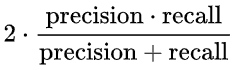


Der F1-Score für die Klasse 0 berechnet sich zum Beispiel als 2 * (0,532258*0,622642/(0,532258+0,622642)) = 0,573913.

Das Ergebnis wird immer zwischen 0 und 1 liegen; ein höherer Wert ist besser.

.* Harmonic mean: https://en.wikipedia.org/wiki/Harmonic_mean

In [ ]:
# Challenge Solution: Calculate Precision and Recall using the classification report

# In sklearn's classification_report, Precision and F-score are set to 0.0 in labels with no predicted samples,
# and a warning is raised. Setting zero_division=1 ignores this (re-run with zero_division=0 to see the warning)
classification_rep = classification_report(y_true=y_test, y_pred=y_pred, output_dict=True, zero_division=1) 
print('Classification report:')
display(pd.DataFrame(classification_rep).T)

## Schritt 10: Verbesserung des Modells

Hier sind nur ein paar Codeschnipsel, die Sie ausprobieren können.

In [ ]:
# View misclassified examples
misclassifications = y_pred != y_test
X_test_split.loc[misclassifications, :]

In [ ]:
# Compare mean values for misclassifications (e.g. false negatives for cluster 2) versus true data of that label
false_negatives_level_2 = (y_test == 2) & (y_pred != y_test)
false_negatives_level_2_df = X_test_split.loc[false_negatives_level_2, :]

print(f'Mean values where LTV Cluster == 2:')
display(pd.DataFrame(df_merged.loc[df_merged['LTV_Cluster'] == 2].select_dtypes(np.number).mean()).T)

print(f'Mean values for False Negatives for LTV Cluster 2:')
display(pd.DataFrame(false_negatives_level_2_df.select_dtypes(np.number).mean()).T)

In [ ]:
# Ideas for additional frequency features (would need to be calculated wiith the original R,F,M columns)

# Frequency / Lifespan (note the +1 is necessary to avoid division by zero errors)
df_customer['Frequency_over_Lifespan'] = df_customer['Frequency'] / (df_customer['Lifespan'] + 1)

# Number of item-day combinations, i.e. how many unique items are bought per purchase?
# Reflects the fact that there is one row per item bought per day
df_item_day_combinations = df_pre.groupby('CustomerID').InvoiceDate.count().reset_index()
df_item_day_combinations.columns = ['CustomerID','Item_day_Combinations']
df_customer = pd.merge(df_customer, df_item_day_combinations, on='CustomerID')

# Another idea would be to incorporate a feature describing the sum of item quantities per day
# i.e. how many total items are bought per purchase?

In [ ]:
# Hint for how to try another model, e.g. XGBoost Multiclassification Model
# You can of course try a hyperparameter search, see the options at:
# https://xgboost.readthedocs.io/en/stable/parameter.html

xgb_model = xgb.XGBClassifier(max_depth=5,
                              learning_rate=0.1,
                              objective='multi:softprob', # Multiclass classification with softmax probabilities
                              eval_metric='mlogloss', # Multiclass Log Loss; the default for this objective
                              n_jobs=-1,
                              use_label_encoder=False)

xgb_model.fit(X_train, y_train)

# Print train and test accuracy, and classification report
print(f'Training set accuracy: {(xgb_model.score(X_train, y_train))}')
print(f'Test set accuracy: {xgb_model.score(X_test[X_train.columns], y_test)}')

y_pred_xgb = xgb_model.predict(X_test)

classification_rep = classification_report(y_true=y_test, y_pred=y_pred_xgb, output_dict=True, zero_division=1) 
print('Classification report:')
display(pd.DataFrame(classification_rep).T)

# Display prediction confusion matrix
df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred_xgb))
print('Confusion Matrix (predicted class = horizontal; actual class = vertical):')
display(df_confusion_matrix)